<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-стационарность-модели" data-toc-modified-id="Проверка-на-стационарность-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка на стационарность модели</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготова-признаков" data-toc-modified-id="Подготова-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготова признаков</a></span></li><li><span><a href="#Подборка-лучшей-модели" data-toc-modified-id="Подборка-лучшей-модели-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подборка лучшей модели</a></span><ul class="toc-item"><li><span><a href="#Модель-Линейная-регрессия" data-toc-modified-id="Модель-Линейная-регрессия-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Модель Линейная регрессия</a></span></li><li><span><a href="#Модель-Случайный-Лес" data-toc-modified-id="Модель-Случайный-Лес-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Модель Случайный Лес</a></span></li><li><span><a href="#Модель-Catboost" data-toc-modified-id="Модель-Catboost-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Модель Catboost</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Модель LightGBM</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# загрузка библиотек
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# загружаем данные 
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
# проверка, что индекс монотонный
df.index.is_monotonic

True

In [4]:
# получение последних 5 строк таблицы
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [5]:
# общий анализ данных
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# ресемплирование по одному часу
df = df.resample('1H').sum()

In [7]:
# проверяем на наличие пропущенных значений
print('Всего NaN:',df.isnull().sum())

Всего NaN: num_orders    0
dtype: int64


In [8]:
# проверка на дубликаты
print('Кол-во дубликатов',df.duplicated().sum())

Кол-во дубликатов 4165


In [9]:
# проверка численных значений методом descibe()
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Построим график рассеяния для почасовых данных

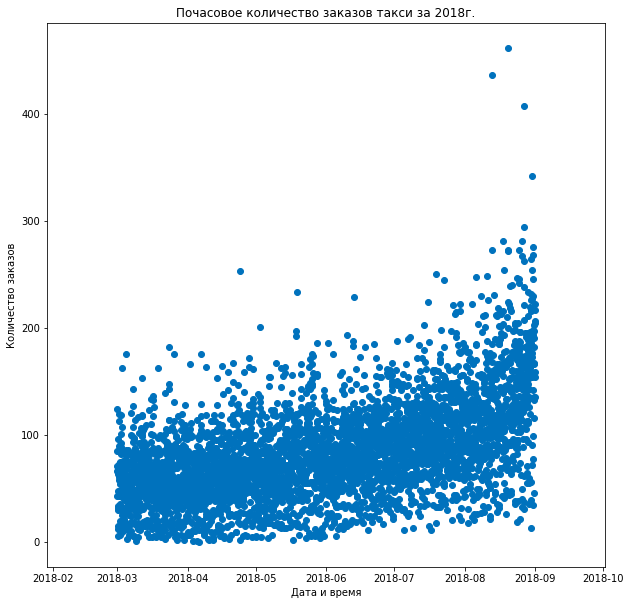

In [10]:
# Создание фигуры 
fig, ax = plt.subplots(figsize=(10, 10))

# Добавление x-axis и y-axis
ax.scatter(df.index.values,
           df['num_orders'],
           color='#0072BD')

# Установление заголовоков и названий для осей
ax.set(xlabel="Дата и время",
       ylabel="Количество заказов",
       title="Почасовое количество заказов такси за 2018г.")

plt.show()

**Вывод:**  У нас есть количество заказов за полгода 2018 года с марта по сентябрь на каждый час. Набор данных всего содержит 26 496  строк и 1 столбец с количеством заказов такси. Результаты:
* В данных нет пропущенных (NaN) значений
* В данных есть 4165 дубликатов, однако эти дубликаты могут являться следствием большого количества заказов такси примерно в одно время.
* График рассеяния показал что вне зависимости от времени большинство заказов приходится на промежуток от 0 до 100 заказов, однако ближе к сентябрю 2018 (2019-09), минимальное кол-во заказов увеличилось, а также видны необычные выбросы в данных.

## Анализ

### Проверка на стационарность модели

Готово, можно перейти к анализу.

Задача прогнозирования временного ряда состоит в построении модели, которая по историческим данным предскажет будущие значения временного ряда. Чтобы построить модель прогнозирования временных рядов, необходимо сначала преобразовать любой нестационарный ряд в стационарный. Стационарный временной ряд — это ряд, в котором среднее значение и стандартное отклонение не меняются со временем (не имеют тренда).

Построим гистрограмму для количества заказов в зависимости от времени:

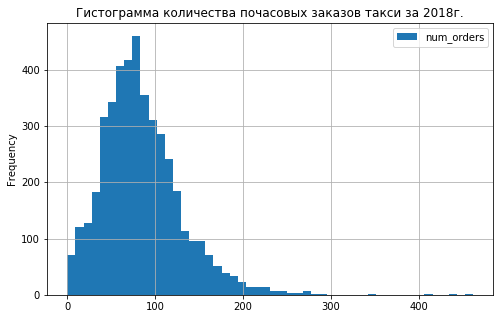

In [11]:
df.plot(kind='hist', bins=50,figsize=(8,5),title='Гистограмма количества почасовых заказов такси за 2018г.', grid=True);

Распределение приняло форму распледеления Гаусса (нормальное распределение) со сдвигом вправо.

Увеличим шаг и посмотрим на данные по месяцам:

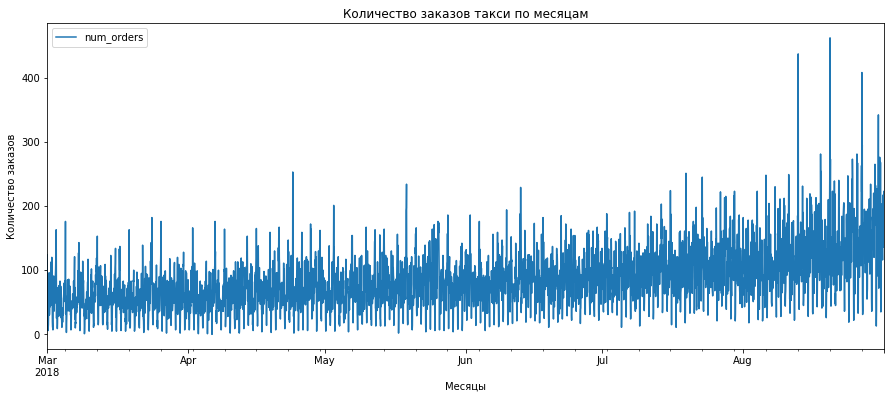

In [12]:
ax = df.plot(figsize=(15, 6))
ax.set_xlabel("Месяцы")
ax.set_ylabel("Количество заказов")
plt.title('Количество заказов такси по месяцам');

Чтобы уменьшить разность временного ряда, рассмотрим тренд, сезонность и остатки декомпозоции.

In [13]:
decomposed = seasonal_decompose(df)

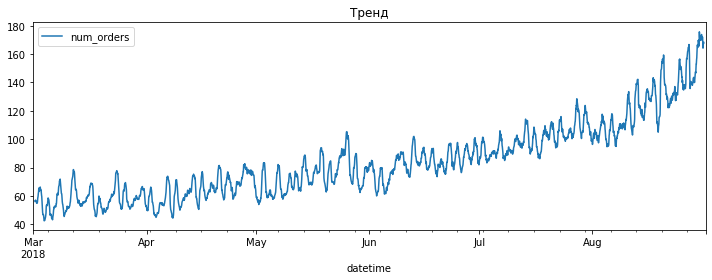

In [14]:
# Построение графикa тренда
decomposed.trend.plot(ax=plt.gca(),figsize=(10, 4))
plt.title('Тренд')
plt.tight_layout()

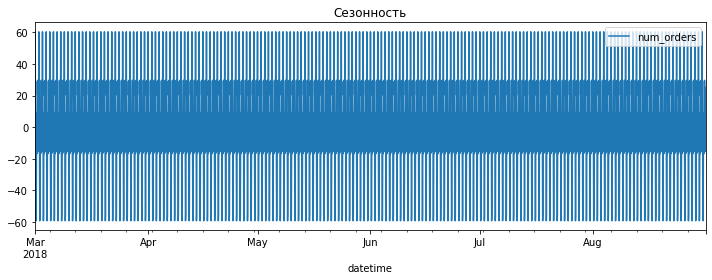

In [15]:
# Построение графикa сезонности
decomposed.seasonal.plot(ax=plt.gca(),figsize=(10, 4))
plt.title('Сезонность')
plt.tight_layout()

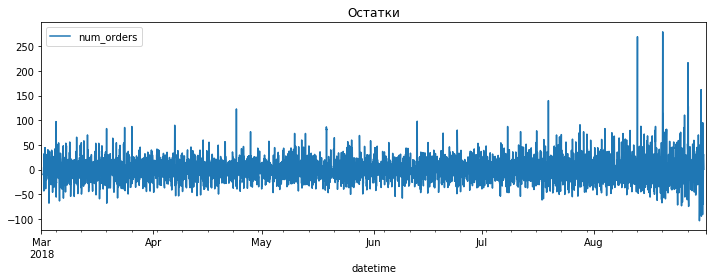

In [16]:
# Построение графикa остатков
decomposed.resid.plot(ax=plt.gca(),figsize=(10, 4))
plt.title('Остатки')
plt.tight_layout()

Построим график с сезонной составляющей (переодически повторяющейся компонентой) за один день середины (16) августа 2018 г. (перед повышением тренда в сентябре)

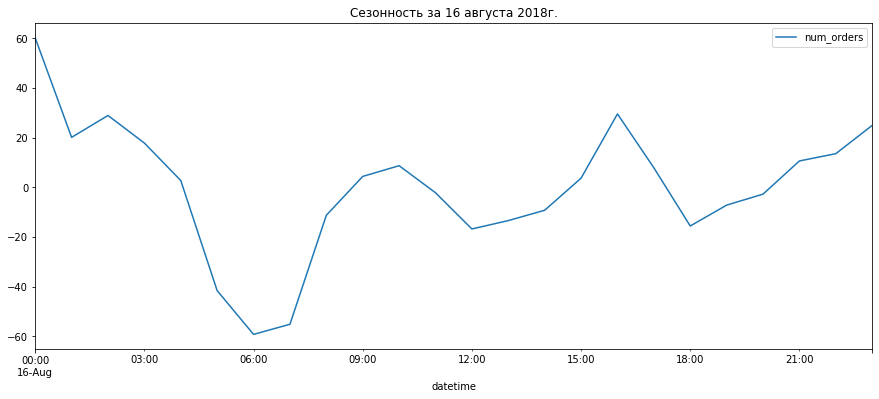

In [17]:
decomposed.seasonal['2018-08-16'].plot(figsize=(15, 6))
plt.title('Сезонность за 16 августа 2018г.');

Для сравнения построим такой же график для другого дня, например в середине (16) марта 2018г. 

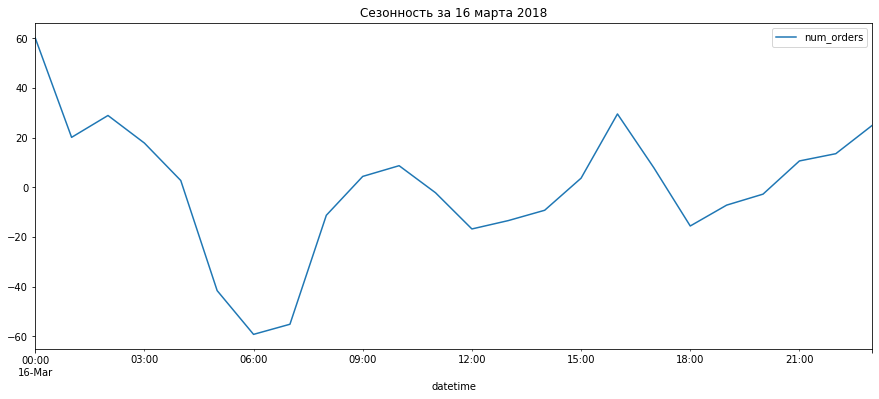

In [18]:
decomposed.seasonal['2018-03-16'].plot(figsize=(15, 6))
plt.title('Сезонность за 16 марта 2018');

Оба графика выглядят идентичными друг другу, то есть сезонность кажется независимой от времени.

**Вывод:**
Гистограмма принимает форму нормального распределения (распределения Гаусса) со сдвигом вправо, но среднее значение изменяется на графике 'Tренда' по мере приближения графика к сентябрю 2018.

Чтобы сделать данные стационарными, мы можем вычеслить разность временного ряда

In [19]:
# сделаем копию датафрейма с помощью метода .copy()
df_copy = df.copy()

# Из данных за январь-июнь 2018 нужно вычесть результат вызова метода shift().
df = df - df_copy.shift()
df.dropna(inplace=True)

Text(0, 0.5, 'Количество заказов')

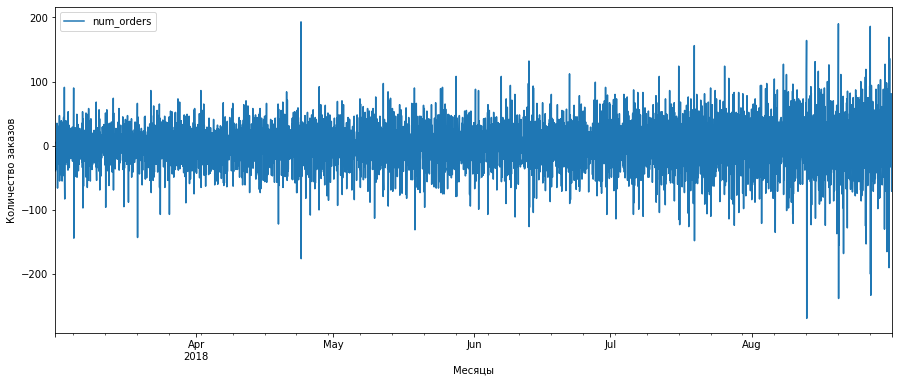

In [20]:
ax = df.plot(figsize=(15, 6));
ax.set_xlabel("Месяцы")
ax.set_ylabel("Количество заказов")

**Вывод:**  Теперь временной ряд стал стационарным.

## Обучение

### Подготова признаков

Создание признаков для одношагового прогноза с горизонтом в один час

In [21]:
# Создание функции для признаков
def make_features(data, max_lag, rolling_mean_size):
    # Формирование календарных признаков
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Формирование отстающих признаков
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # Добавление признака скользящего среднего
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

max_lag подбирается эксперементально. Вызовем функцию max_features() с max_lag = 4 и rolling_mean_size = 5.

In [164]:
make_features(df, 2, 24)

Разбиение данных на train, valid и test выборки. При работе с временными рядами перемешивать данные при разбиении на выборки нельзя

In [165]:
train_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

Создание признаков и целевых признаков данных

In [166]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Подборка лучшей модели

Нам необходимо эффективно подобрать наиболее эффективную модель, то есть проанализировать несколько модели и сравнить их RMSE моделей (оценка качества) и выбрать ту которая наиболее близка к нулю. Также отследим время обучения моделей. Мы обучим и проанализируем следующие модели:

* Linear Regression (Линейная регрессия)
* Random Forest (Случайный лес)
* Catboost
* LightGBM

#### Модель Линейная регрессия

In [167]:
%%time
lr = LinearRegression() # создание класса модели
lr.fit(features_train, target_train) # обучение модели
predicted_train = lr.predict(features_train) # предсказание значений для train
predicted_valid = lr.predict(features_valid) # предсказание значений для valid

# RMSE
print("RMSE обучающей выборки:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE обучающей выборки: 31.44428025513777
RMSE валидационной выборки  43.66342277758313
Wall time: 16 ms


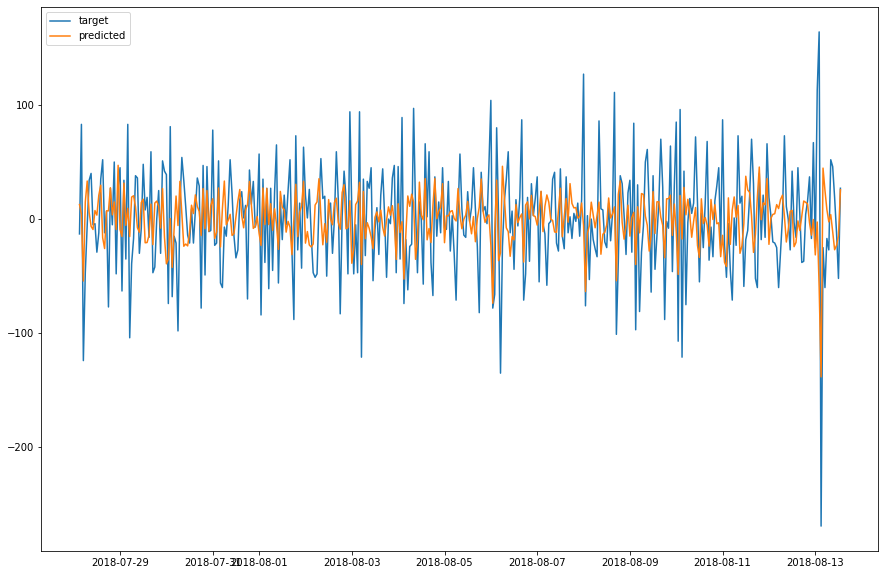

In [168]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

#### Модель Случайный Лес

In [169]:
%%time
rm = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42) # create model class
rm.fit(features_train, target_train) # обучение модели
predicted_train = rm.predict(features_train) # предсказание значений для train
predicted_valid = rm.predict(features_valid) # предсказание значений для valid

# RMSE
print("RMSE обучающей выборки:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE обучающей выборки: 24.644164580449115
RMSE валидационной выборки  38.01648032573997
Wall time: 989 ms


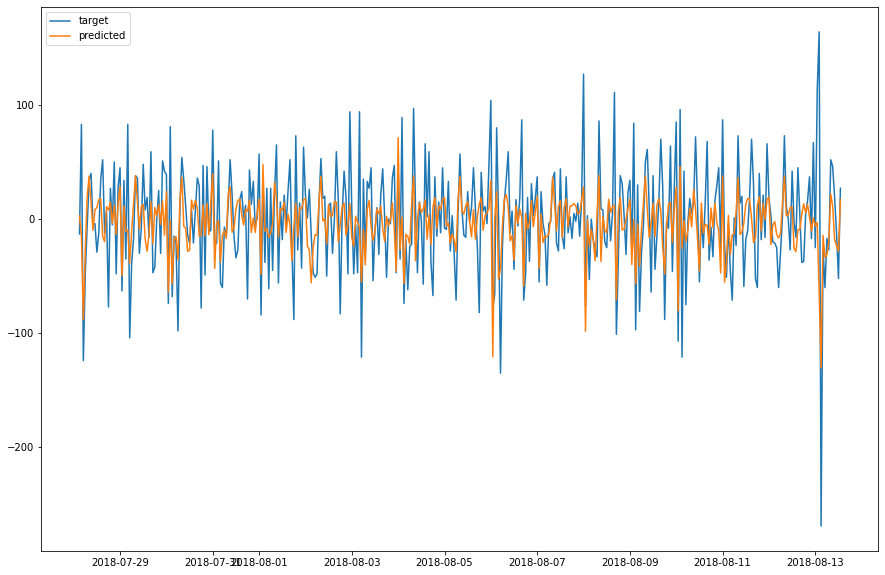

In [170]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

#### Модель Catboost

In [171]:
%%time
cb = CatBoostRegressor(n_estimators=200,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3, 
                       task_type='CPU',
                       random_state=42, 
                       verbose=False)
cb.fit(features_train, target_train) # обучение модели
predicted_train = cb.predict(features_train) # предсказание значений для train
predicted_valid = cb.predict(features_valid) # предсказание значений для valid

# RMSE
print("RMSE обучающей выборки:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE обучающей выборки: 19.760898473572702
RMSE валидационной выборки  34.24753479565059
Wall time: 550 ms


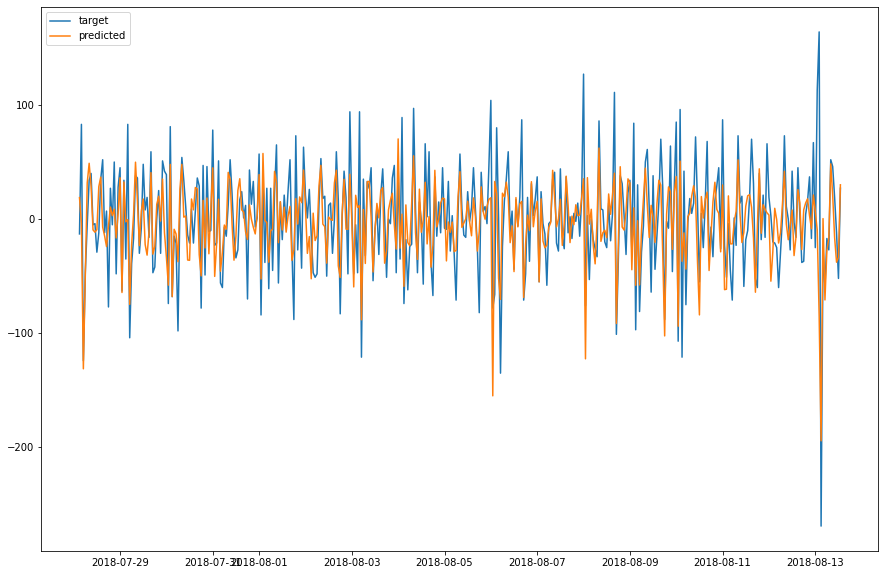

In [172]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

#### Модель LightGBM 

In [173]:
%%time
lgb = lgb.LGBMRegressor(n_estimators=200, 
                          learning_rate=0.1, 
                          num_leaves=10, 
                          max_depth=20, 
                          random_state=42) # создание класса модели
lgb.fit(features_train, target_train) # обучение модели
predicted_train = lgb.predict(features_train) # предсказание значений для train
predicted_valid = lgb.predict(features_valid) # предсказание значений для valid

# RMSE
print("RMSE обучающей выборки:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE обучающей выборки: 19.701847989869247
RMSE валидационной выборки  35.29929223049786
Wall time: 490 ms


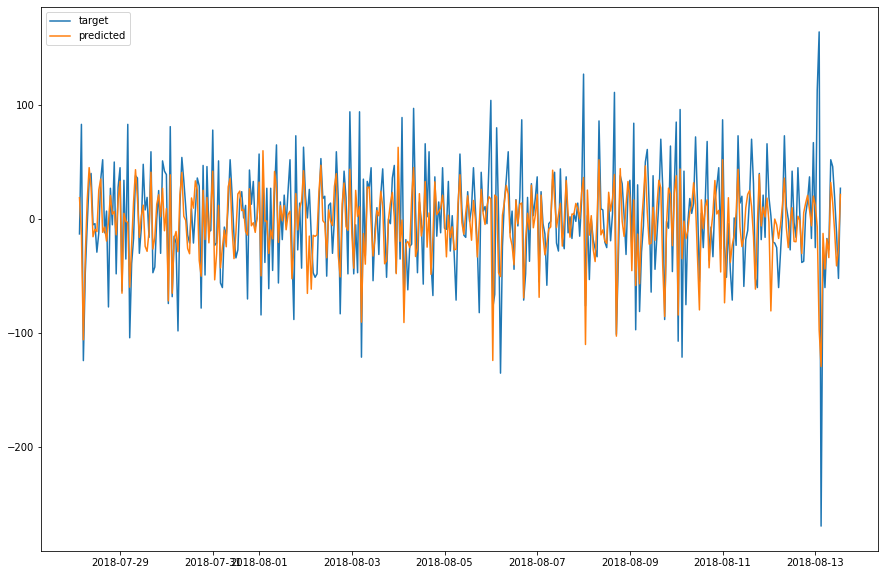

In [174]:
a = target_valid.tolist()
b = predicted_valid.tolist()
c = target_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

**Вывод:** Всего было проанализировано 4 модели, среди которых были получены следующие результаты:

|модели|время обучения/сек|качество valid(RMSE)|
|---|---|---|
|LinearRegression|0.00645|42.7|
|RandomForest|0.884|36.9|
|CatBoost|4.91|33.6|
|LightGBM|2.17|34.0|

Самой быстрой моделью является линейная регрессия, но RMSE этой модель гораздо хуже остальных моделей (42.7). Catboost имеет наилучшее значение RMSE (33.6), но по скорости немного уступает LightGBM (Catboost - 4.91s, LightGBM - 2.17s). У LightGBM RMSE = 34. 

**Вывод:** несмотря на то, что Catboost является на 2.74 секунды медленней, чем LightGBM, качество этой модели наиболее высокое. Для дальнейшего анализа выбираем *Caboost*.

## Тестирование

* Тестирование модели на тестовой выборке

In [175]:
%%time
model = CatBoostRegressor(n_estimators=200,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3, 
                       task_type='CPU',
                       random_state=42, 
                       verbose=False)
model.fit(features_train, target_train) # обучение модели
predicted_test = model.predict(features_test) # предсказание значение

# RMSE тестовой выборки
print("RMSE тестовой выборки:", mean_squared_error(target_test, predicted_test) ** 0.5)

RMSE тестовой выборки: 46.224814360361144
Wall time: 1.38 s


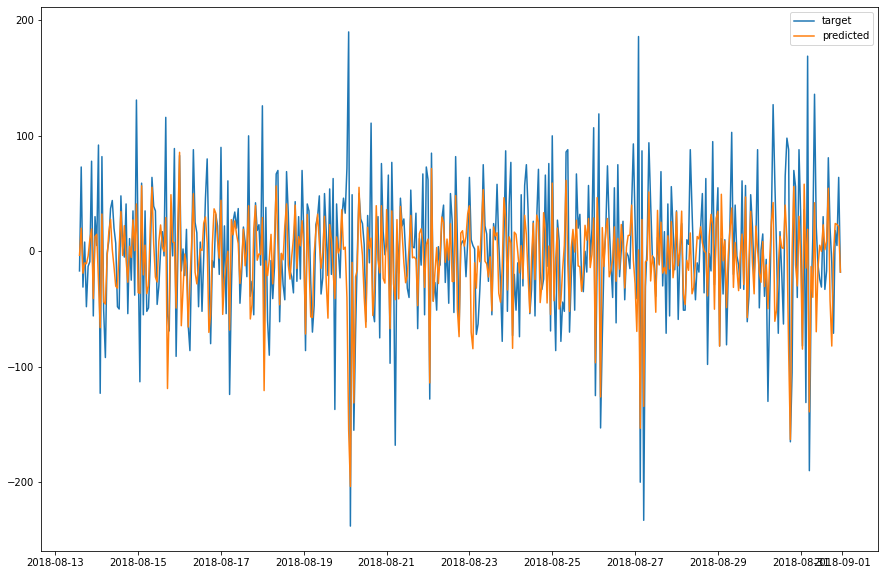

In [176]:
a = target_test.tolist()
b = predicted_test.tolist()
c = target_test.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ниже моя попытка построить график, но без Керас никак не выходит
</div>

* Рассчитаем RMSE с исходными данными.

Вызовем функцию make_features с max_lag = 10, roll_mean_size = 12 для df_copy, которую мы создавали ранее

In [177]:
make_features(df, 2, 24)

In [178]:
# разбиение на выборки
train, test = train_test_split(df_copy, shuffle=False, test_size=0.1)
train = train.dropna()

In [179]:
# Создание признаков и целевых признаков данных
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

**Вывод:** На тестовой выборке и на изначальном датасете модель показала резульат RMSE хуже, чем на валидационной: (44.6 против 33.6), но это является дапустимым значением качества для заказчика (требование >=48 RMSE)

# Общий вывод

Мы подобрали и построили модель для прогнозирования количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. catbost - модель с наилучшим RMSE, равным 44.6 на тестовой выборке и 33.6 на валидационной. Время обучения в среднем равно 4 секундам.